In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


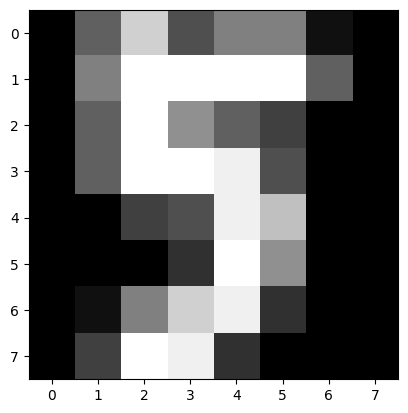

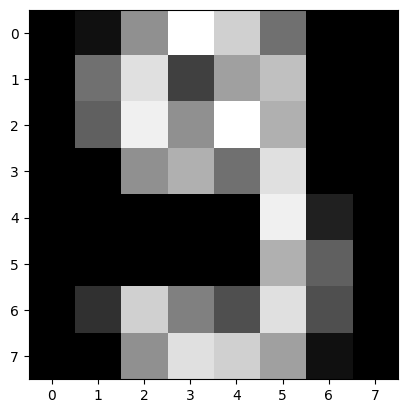

In [3]:
import numpy as numpy
import matplotlib.pyplot as plt

img = digits.images[33]


def print_img(img):
    assert 2 == len(img.shape)
    plt.figure()
    plt.gray()
    plt.imshow(img, interpolation="nearest")  # bicubic, nearest
    plt.show()


print_img(img)


def print_data(data):
    data_temp = data.reshape(8, 8)
    print_img(data_temp)
print_data(digits.data[39])


In [4]:
from sklearn import model_selection
import numpy as np

filter_mask = np.logical_or(target == 3, target == 9)

X_all = data[filter_mask]
y_all = target[filter_mask]

y_all[y_all == 3] = -1
y_all[y_all == 9] = 1
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(
        X_all, y_all, test_size=0.4, random_state=0)

In [5]:
from sklearn.preprocessing import MinMaxScaler


def features2d(datas):
    features = []
    for data in datas:
        mask = data > 12
        temp = [data[18]+data[26]+data[34]+data[42],
                data[11]+data[19]-data[35]-data[43]]
        features.append(temp)

    # normalize
    features_norm = MinMaxScaler().fit_transform(features)

    return features_norm

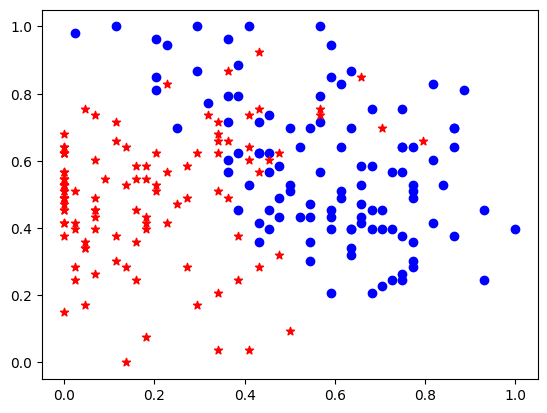

In [6]:
# X_train
# y_train

features = features2d(X_train)


def draw_feature(features, label):
    for feature, y in zip(features, label):
        if y == 3 or y == -1:
            marker = "*"
            color = "red"
        elif y == 9 or y == 1:
            marker = "o"
            color = "blue"
        plt.scatter(feature[0], feature[1], marker=marker, color=color)
        # plt.show()


draw_feature(features, y_train)

In [7]:
def nearest_mean(training_features, training_labels, test_festures):
    t_features = np.array(training_features)
    t_labels = np.array(training_labels)

    f_negetive = t_features[t_labels == -1].mean(axis=0)
    f_positive = t_features[t_labels == 1].mean(axis=0)

    labels = []
    for f in test_festures:
        if abs(f-f_negetive).sum() > abs(f-f_positive).sum():
            labels.append(1)
        else:
            labels.append(-1)

    return labels


train_features = features2d(X_train)
x_new = features2d(X_test)

test_labels = nearest_mean(train_features, y_train, x_new)
train_labels = nearest_mean(train_features, y_train, train_features)

training_error = abs(train_labels - y_train).sum()/(2*len(y_train))
test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
print(f"training error: {training_error}")
print(f"test error: {test_error}")

training error: 0.1336405529953917
test error: 0.11643835616438356


40000


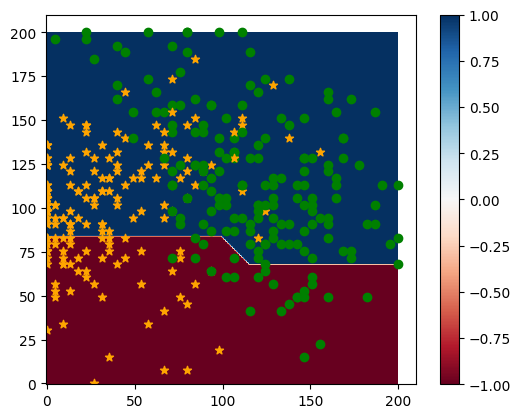

40000


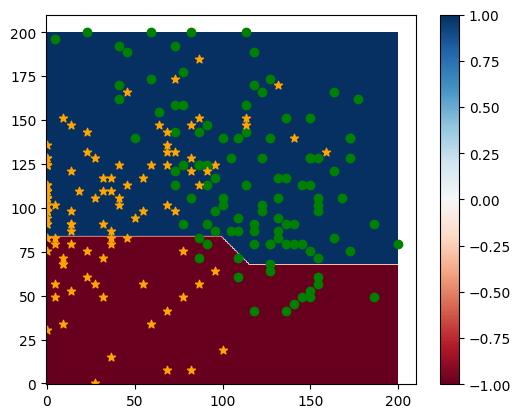

In [8]:
import itertools

# f_negetive = t_features[t_labels == -1].mean()
# f_positive = t_features[t_labels == 1].mean()


def draw_decision_region(X, y):
    f1 = np.linspace(0, 1, 200)
    f2 = np.linspace(0, 1, 200)

    mesh_f = list(itertools.product(f1, f2))
    mesh_decision = nearest_mean(train_features, y_train, mesh_f)
    print(len(mesh_decision))

    cmap = plt.cm.RdBu
    norm = plt.Normalize(-1, 1)

    plt.imshow(np.array(mesh_decision).reshape(200, 200),
               cmap=cmap, norm=norm, origin='lower')
    plt.colorbar()
    X_all_scale = [x*200 for x in features2d(X)]
    # draw_feature(X_all_scale,y_all)
    for feature, y in zip(X_all_scale, y):
        if y == -1:
            marker = "*"
            color = "orange"
        elif y == 1:
            marker = "o"
            color = "green"
        plt.scatter(feature[0], feature[1], marker=marker, color=color)
    plt.show()


draw_decision_region(X_all, y_all)
draw_decision_region(X_train, y_train)


exercise 3

3.1

In [20]:
def fit_lad(training_features, training_labels):
    t_features = np.array(training_features)
    t_labels = np.array(training_labels)

    x_negetive = t_features[t_labels == -1]
    x_positive = t_features[t_labels == 1]
    mu_negetive = x_negetive.mean(axis=0)
    mu_positive = x_positive.mean(axis=0)

    covmat = ((x_negetive - mu_negetive).T @ (x_negetive - mu_negetive) +
              (x_positive - mu_positive).T @ (x_positive - mu_positive)
              ) / len(training_labels)

    counts = [np.sum(t_labels == k) for k in {-1, 1}]
    p = [count / len(t_labels) for count in counts]

    return [mu_negetive, mu_positive], covmat, p


fit_lad(X_train, y_train)
mu, covmat, p = fit_lad(features2d(X_train), y_train)

3.2

In [21]:
def predict_lda(mu, covmat, p, test_features):
    [mu_neg, mu_pos] = mu
    # print((mu_pos - mu_neg).shape)
    # print(covmat.shape)
    # print(np.linalg.pinv(covmat).shape) # it should be inv not pinv, but I don't know why covmat is a singular matrix in my code
    beta = 2 * np.linalg.pinv(covmat) @ mu_pos - mu_neg.T
    b = mu_neg @ np.linalg.pinv(covmat) @ mu_neg.T - \
        mu_pos @ np.linalg.pinv(covmat) @ mu_pos.T

    return np.sign(test_features @ beta + b)


train_predicted = predict_lda(mu, covmat, p, features2d(X_train))
test_predicted = predict_lda(mu, covmat, p, features2d(X_test))

training_error = abs(train_predicted - y_train).sum()/(2*len(y_train))
test_error = abs(test_predicted - y_test).sum()/(2*len(y_test))
print(f"training error: {training_error}")
print(f"test error: {test_error}")

training error: 0.4792626728110599
test error: 0.4246575342465753


3.3

40000


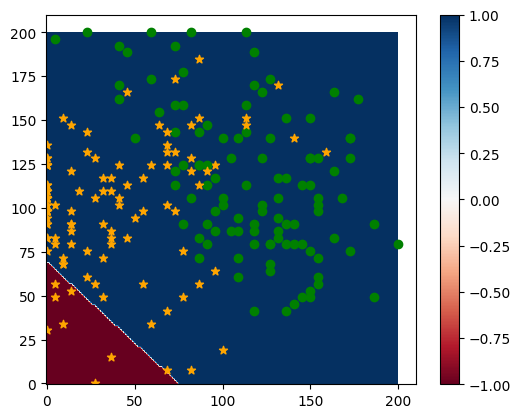

In [25]:
# def draw_decision_region2(X, y):
f1 = np.linspace(0, 1, 200)
f2 = np.linspace(0, 1, 200)

mesh_f = list(itertools.product(f1, f2))
mesh_decision = predict_lda(mu, covmat, p, mesh_f)
print(len(mesh_decision))

cmap = plt.cm.RdBu
norm = plt.Normalize(-1, 1)

plt.imshow(np.array(mesh_decision).reshape(200, 200),
            cmap=cmap, norm=norm, origin='lower')
plt.colorbar()

X_scale = [x*200 for x in features2d(X_train)]

# Create a dictionary to map labels to colors and markers
color_dict = {-1: "orange", 1: "green"}
marker_dict = {-1: "*", 1: "o"}

# draw_feature(X_all_scale,y_all)
for feature, y in zip(X_scale, y_train):
    color = color_dict[y]
    marker = marker_dict[y]
    plt.scatter(feature[0], feature[1], marker=marker, color=color)

plt.show()


3.4

In [26]:

digits = load_digits()


X_39 = np.concatenate([digits.data[digits.target==3], digits.data[digits.target==9]])
y_39 = np.concatenate([np.ones(np.sum(digits.target==3)), -1*np.ones(np.sum(digits.target==9))])


lda = LDA()

# 10-fold cross-validation 
scores = cross_val_score(lda, X_39, y_39, cv=10)

print("LDA accuracy (custom implementation): {:.2f}".format(np.mean(scores)))

# scikit-learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_sklearn = LinearDiscriminantAnalysis()
scores_sklearn = cross_val_score(lda_sklearn, X_39, y_39, cv=10)

print("LDA accuracy (scikit-learn): {:.2f}".format(np.mean(scores_sklearn)))


LDA accuracy (custom implementation): 0.98
LDA accuracy (scikit-learn): 0.98
